In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from astra.torch.models import EfficientNet,ResNetClassifier, MLP, MLPClassifier, EfficientNetClassifier
# from astra.torch.utils import count_params
# print(count_params(EfficientNetClassifier()))
# print(count_params(ResNetClassifier()))

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn as nn
import copy
import time
import os
import torchvision.models as models

import argparse
from torch.utils.data import Subset
import csv
device = torch.device('cuda')
from ResNet import *
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

### transforms for downstream tasks

In [6]:
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data_final/test_data.pt")
loaded_data1 = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/new_dataset_Bangladesh_14k.pt")
images= loaded_data1['images']
labels = loaded_data1['labels']
# images = images / 255
# images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
images1 = loaded_data['images']
labels1 = loaded_data['labels']
# images1 = images1 / 255
# images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
# print(images1.shape)
# print(labels1.shape)
# print(images.shape)
# print(labels.shape)
train_images = images
train_labels = labels
test_images = images1
test_labels = labels1
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

torch.Size([14000, 3, 224, 224])
torch.Size([14000])
torch.Size([4500, 3, 224, 224])
torch.Size([4500])


In [7]:
# loaded_datad1= torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data_final/delhi_data_2250.pt")
# imagesd= loaded_datad1['images']
# labelsd = loaded_datad1['labels']

# images1 = images1 / 255
# images1 = (images1 print(images1.shape)
# print(labels1.shape)- images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)


In [8]:
# train_images= torch.cat((train_images,imagesd),0)
# train_labels= torch.cat((train_labels,labelsd),0)
# print(train_images.shape)
# print(train_labels.shape)

In [9]:
train_labels_count = (train_labels == 1).sum()
test_labels_count = (test_labels == 1).sum()

print("Number of train labels with value 1:", train_labels_count)
print("Number of test labels with value 1:", test_labels_count)

Number of train labels with value 1: tensor(1697)
Number of test labels with value 1: tensor(521)


In [10]:
train_images.dtype, train_labels.dtype, test_images.dtype, test_labels.dtype


(torch.float32, torch.float32, torch.float32, torch.uint8)

In [11]:
train_labels = train_labels.type(torch.uint8)
test_labels = test_labels.type(torch.uint8)

In [12]:
train_images.dtype, train_labels.dtype, test_images.dtype, test_labels.dtype


(torch.float32, torch.uint8, torch.float32, torch.uint8)

In [13]:
train_labels_count = (train_labels == 1).sum()
test_labels_count = (test_labels == 1).sum()

print("Number of train labels with value 1:", train_labels_count)
print("Number of test labels with value 1:", test_labels_count)
# test_images=transform_test(test_images)

Number of train labels with value 1: tensor(1697)
Number of test labels with value 1: tensor(521)


### Data preporcessing for how much percentage of the data is used for finetune

In [14]:
# train_images=transform_eval(train_images)


In [15]:
# print(train_images.shape)
# print(test_images.shape)
train_set=torch.utils.data.TensorDataset(train_images,train_labels)
test_set=torch.utils.data.TensorDataset(test_images,test_labels)
train_loader=torch.utils.data.DataLoader(train_set,batch_size=256,shuffle=True,num_workers=8)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=256,shuffle=False,num_workers=8)

In [16]:
len(train_set)

14000

In [17]:
base_encoder=torchvision.models.efficientnet_b0(pretrained=False)
# base_encoder

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
class SimCLR_model(nn.Module):
    def __init__(self, base_encoder, projection_dim, n_features):
        super(SimCLR_model, self).__init__()

        self.base_encoder = base_encoder
        self.n_features = n_features
        self.base_encoder.classifier[1]=nn.Linear(n_features, n_features)
        self.base_encoder.linear = Identity()
        self.projectionHead = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(self.n_features),
            nn.ReLU(), #non-linearity
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim),
        )

    def forward(self, x_i, x_j):
        h_i = self.base_encoder(x_i)
        h_j = self.base_encoder(x_j)
        
        z_i = self.projectionHead(h_i)
        z_j = self.projectionHead(h_j)
        
        return h_i, h_j, z_i, z_j

In [19]:
simclr_model = SimCLR_model(base_encoder, 128, 1280)    
# simclr_model

In [20]:
projection_dim=128
n_features= base_encoder.classifier[1].in_features
net= SimCLR_model(base_encoder, projection_dim, n_features)
net= net.to(device)
# net
print(base_encoder.classifier[1].weight) #weights of the linear layer before loading the model with SimCLR

path_paramsend = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/Saved_model/paramsend_bs_restart_r_bk_DB_efficient.pt"
checkpoint = torch.load(path_paramsend, map_location=torch.device('cpu'))
loss= checkpoint['loss']
epoch = checkpoint['epoch']
start_epoch=0
net.load_state_dict(checkpoint['net'])
epoch
# net

Parameter containing:
tensor([[ 0.0181, -0.0185, -0.0234,  ..., -0.0030, -0.0252, -0.0211],
        [ 0.0094,  0.0214,  0.0185,  ...,  0.0115, -0.0263, -0.0145],
        [ 0.0079,  0.0100, -0.0262,  ..., -0.0125, -0.0145,  0.0021],
        ...,
        [ 0.0180,  0.0102, -0.0221,  ...,  0.0044,  0.0049, -0.0230],
        [-0.0206, -0.0023,  0.0223,  ...,  0.0259, -0.0208,  0.0201],
        [-0.0039,  0.0024, -0.0066,  ..., -0.0134, -0.0202, -0.0181]],
       device='cuda:0', requires_grad=True)


300

In [21]:
net.base_encoder.classifier[1].weight #weights of the linear layer after loading the model with SimCLR

Parameter containing:
tensor([[-0.0010,  0.0072,  0.0007,  ..., -0.0016,  0.0007, -0.0020],
        [ 0.0004, -0.0083, -0.0070,  ...,  0.0019, -0.0052, -0.0104],
        [ 0.0051, -0.0041,  0.0010,  ..., -0.0082, -0.0017,  0.0036],
        ...,
        [ 0.0020,  0.0015,  0.0045,  ..., -0.0036,  0.0002,  0.0062],
        [ 0.0032, -0.0015,  0.0014,  ..., -0.0029,  0.0034,  0.0076],
        [ 0.0004,  0.0012, -0.0103,  ...,  0.0145,  0.0084, -0.0117]],
       device='cuda:0', requires_grad=True)

In [22]:
net_eval= net.base_encoder
net_eval.classifier[1].weight

# net_eval

Parameter containing:
tensor([[-0.0010,  0.0072,  0.0007,  ..., -0.0016,  0.0007, -0.0020],
        [ 0.0004, -0.0083, -0.0070,  ...,  0.0019, -0.0052, -0.0104],
        [ 0.0051, -0.0041,  0.0010,  ..., -0.0082, -0.0017,  0.0036],
        ...,
        [ 0.0020,  0.0015,  0.0045,  ..., -0.0036,  0.0002,  0.0062],
        [ 0.0032, -0.0015,  0.0014,  ..., -0.0029,  0.0034,  0.0076],
        [ 0.0004,  0.0012, -0.0103,  ...,  0.0145,  0.0084, -0.0117]],
       device='cuda:0', requires_grad=True)

In [23]:
net_eval

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [24]:
classes = ('positive', 'negetive')
# net_eval= base_encoder
n_features= net_eval.classifier[1].in_features
# net_eval.linear=nn.ReLU()
# net_eval.bn1=nn.Linear(n_features,n_features)
# net_eval.act1=nn.ReLU()
net_eval.linear=nn.Linear(n_features,2)
# net_eval.bn1=nn.Softmax(dim=1)
net_eval.classifier[1].weight


Parameter containing:
tensor([[-0.0010,  0.0072,  0.0007,  ..., -0.0016,  0.0007, -0.0020],
        [ 0.0004, -0.0083, -0.0070,  ...,  0.0019, -0.0052, -0.0104],
        [ 0.0051, -0.0041,  0.0010,  ..., -0.0082, -0.0017,  0.0036],
        ...,
        [ 0.0020,  0.0015,  0.0045,  ..., -0.0036,  0.0002,  0.0062],
        [ 0.0032, -0.0015,  0.0014,  ..., -0.0029,  0.0034,  0.0076],
        [ 0.0004,  0.0012, -0.0103,  ...,  0.0145,  0.0084, -0.0117]],
       device='cuda:0', requires_grad=True)

In [25]:
net_eval

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [26]:
net_eval.to(device)
# criterion = nn.CrossEntropyLoss()
# criterion = criterion.to(device)
# optimizer = torch.optim.Adam(net_eval.parameters(), lr=0.0001)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### fine-tune the downstram model  and predict on test data

In [27]:
# net_eval
start_epoch=0


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_eval.parameters(), lr=0.001)
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []
test_f1_scores = []
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []
for epoch in range(30):
    net_eval.train()
    true_labels = []
    pred_labels = []        
    running_loss = 0.0
    for i ,(inputs, labels) in enumerate(train_loader):
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        output = net_eval(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(output, 1)
        true_labels.extend(labels.data.cpu().numpy())
        pred_labels.extend(preds.data.cpu().numpy())
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = accuracy_score(true_labels, pred_labels)
    train_accuracies.append(train_accuracy)
    train_precision = precision_score(true_labels, pred_labels)
    train_precisions.append(train_precision)
    train_recall = recall_score(true_labels, pred_labels)
    train_recalls.append(train_recall)
    train_f1 = f1_score(true_labels, pred_labels)
    train_f1_scores.append(train_f1)
    print(f'Epoch {epoch}, Loss: {epoch_loss}, Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1: {train_f1}')

    with torch.no_grad():
        net_eval.eval()
        true_labels = []
        pred_labels = []
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            output = net_eval(inputs)
            _, preds = torch.max(output, 1)
            true_labels.extend(labels.data.cpu().numpy())
            pred_labels.extend(preds.data.cpu().numpy())
    test_accuracy = accuracy_score(true_labels, pred_labels)
    test_accuracies.append(test_accuracy)
    test_precision = precision_score(true_labels, pred_labels)
    test_precisions.append(test_precision)
    test_recall = recall_score(true_labels, pred_labels)
    test_recalls.append(test_recall)
    test_f1 = f1_score(true_labels, pred_labels)
    test_f1_scores.append(test_f1)
    print(f'Test - Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1: {test_f1}')

        


Epoch 0, Loss: 0.1318079668368612, Accuracy: 0.9577142857142857, Precision: 0.8618205631958088, Recall: 0.7754861520329994, F1: 0.8163771712158809
Test - Accuracy: 0.9, Precision: 0.6360153256704981, Recall: 0.31861804222648754, F1: 0.42455242966751927
Epoch 1, Loss: 0.08082630028256348, Accuracy: 0.9715714285714285, Precision: 0.8982219497240956, Recall: 0.8632881555686506, F1: 0.8804086538461539
Test - Accuracy: 0.896, Precision: 0.8354430379746836, Recall: 0.12667946257197696, F1: 0.21999999999999997
Epoch 2, Loss: 0.05908035595502172, Accuracy: 0.9795, Precision: 0.9341133004926109, Recall: 0.8939304655274013, F1: 0.9135802469135803
Test - Accuracy: 0.9164444444444444, Precision: 0.7695167286245354, Recall: 0.39731285988483683, F1: 0.5240506329113924
Epoch 3, Loss: 0.047607052675315314, Accuracy: 0.9832142857142857, Precision: 0.9419588875453446, Recall: 0.9180907483794932, F1: 0.9298716800954939
Test - Accuracy: 0.8937777777777778, Precision: 0.5439672801635992, Recall: 0.51055662

In [30]:
result_dict = {}

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

percent = "100+25%"
ssl = "SimCLR"
with torch.no_grad():    
    net_eval.eval()
    correct = 0
    total = 0
    y_pred = []
    y_test = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            output = net_eval(inputs)
            _, preds = torch.max(output, 1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
            y_pred.extend(preds.cpu().numpy())
            y_test.extend(targets.cpu().numpy())
    
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    
    print('Test Acc: %.3f%% (%d/%d)' % (100.*correct/total, correct, total))
    print(len(y_pred), len(y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # If needed, class-specific metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    class_precision = precision_score(y_test, y_pred, average=None)
    class_recall = recall_score(y_test, y_pred, average=None)
    class_f1 = f1_score(y_test, y_pred, average=None)

    print("Class-specific Accuracy:", class_accuracy)
    print("Class-specific Precision:", class_precision)
    print("Class-specific Recall:", class_recall)
    print("Class-specific F1 Score:", class_f1)
    result_dict[f"{percent} {ssl}"] = {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}
    print(result_dict)

Test Acc: 90.222% (4060/4500)
4500 4500
Accuracy:  0.9022222222222223
Precision:  0.6085790884718498
Recall:  0.43570057581573896
F1 Score:  0.5078299776286354
Confusion Matrix:
[[3833  146]
 [ 294  227]]
Class-specific Accuracy: [0.96330736 0.43570058]
Class-specific Precision: [0.92876181 0.60857909]
Class-specific Recall: [0.96330736 0.43570058]
Class-specific F1 Score: [0.94571922 0.50782998]
{'100+25% SimCLR': {'accuracy': 0.9022222222222223, 'f1': 0.5078299776286354, 'precision': 0.6085790884718498, 'recall': 0.43570057581573896}}


In [ ]:
# y_pred,ytest=prdict(net_eval, test_loader, "30%", "ssl", device,)

In [34]:
import pandas as pd

In [35]:
print(result_dict)

{'100+25% SimCLR': {'accuracy': 0.9537777777777777, 'f1': 0.7815126050420168, 'precision': 0.8631090487238979, 'recall': 0.7140115163147792}}


In [36]:
import pandas as pd
resdf = pd.DataFrame(result_dict)
resdf

,100+25% SimCLR
accuracy,0.953778
f1,0.781513
precision,0.863109
recall,0.714012


In [37]:
import pickle

file_path = "/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/SimCLR_experiments/siclr_result/100+25%_ssl.pkl"
with open(file_path, "wb") as file:
    pickle.dump(result_dict, file)

In [ ]:
import pickle

# Load the dictionaries from the files
with open("dictionary1_ssl.pkl", "rb") as file1, open("merged_dictionary_main.pkl", "rb") as file2:
    dict1 = pickle.load(file1)
    dict2 = pickle.load(file2)

# Merge the dictionaries
merged_dict = {**dict1, **dict2}

# Save the merged dictionary to a file
with open("merged_dictionary_main.pkl", "wb") as file:
    pickle.dump(merged_dict, file)


In [ ]:
# import pickle

# Load the merged dictionary from the file
with open("merged_dictionary_main.pkl", "rb") as file:
    merged_dict = pickle.load(file)

# Print the merged dictionary
print(merged_dict)


{'50% SimCLR': {'accuracy': 0.8941645885286783, 'f1': 0.3454657618753856, 'precision': 0.4835924006908463, 'recall': 0.2687140115163148}, '1% SimCLR': {'accuracy': 0.7966084788029926, 'f1': 0.0860600627521291, 'precision': 0.08074011774600505, 'recall': 0.09213051823416507}, '10% SimCLR': {'accuracy': 0.8674314214463841, 'f1': 0.21221102548903378, 'precision': 0.2775193798449612, 'recall': 0.17178502879078694}, '30% SimCLR': {'accuracy': 0.8766084788029925, 'f1': 0.3177054605626034, 'precision': 0.3735408560311284, 'recall': 0.2763915547024952}, '100% SimCLR': {'accuracy': 0.9054364089775561, 'f1': 0.2914798206278027, 'precision': 0.6587837837837838, 'recall': 0.1871401151631478}, '100% No_SimCLR': {'accuracy': 0.8944638403990025, 'f1': 0.3111979166666667, 'precision': 0.48380566801619435, 'recall': 0.22936660268714013}, '50% No_SimCLR': {'accuracy': 0.8751122194513715, 'f1': 0.29105322763306907, 'precision': 0.35497237569060774, 'recall': 0.24664107485604606}, '30% No_SimCLR': {'accur

In [ ]:
# df=pd.read_csv("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv")
# df
# # resdf = pd.DataFrame(result_dict)
resdf = pd.DataFrame(merged_dict)
resdf



,50% SimCLR,1% SimCLR,10% SimCLR,30% SimCLR,100% SimCLR,100% No_SimCLR,50% No_SimCLR,30% No_SimCLR,10% No_SimCLR,1% No_SimCLR
accuracy,0.894165,0.796608,0.867431,0.876608,0.905436,0.894464,0.875112,0.878504,0.859751,0.89606
f1,0.345466,0.086060,0.212211,0.317705,0.291480,0.311198,0.291053,0.402355,0.264644,0.00000
precision,0.483592,0.080740,0.277519,0.373541,0.658784,0.483806,0.354972,0.411647,0.290805,0.00000
recall,0.268714,0.092131,0.171785,0.276392,0.187140,0.229367,0.246641,0.393474,0.242802,0.00000


In [ ]:
#list to tensor
y_pred = torch.tensor(y_pred)
y_test = torch.tensor(y_test)
def results(y_labels,y_pred,plot_confusion = False):
    y_labels = y_labels.to(device) 
    y_pred = y_pred.to(device)
    print(f"Accuracy = {(y_labels == y_pred).float().mean()}")
    if plot_confusion:
        cm = confusion_matrix(y_labels.cpu(), y_pred.cpu())
        unique_labels = np.unique(y_labels.cpu())
        cm_display = ConfusionMatrixDisplay(cm, display_labels=unique_labels).plot(values_format='d', cmap='Blues')
        plt.show()

Accuracy = 0.8882792592048645


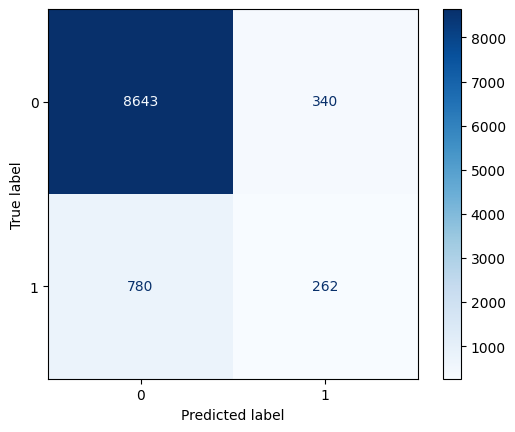

In [ ]:
results(y_test,y_pred,plot_confusion = True)

In [ ]:
import pandas as pd

# Assuming df is your DataFrame
df = pd.read_csv("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv")

# Extract the '100% SSL' column and convert it to a dictionary
ssl_dict = df.set_index('Results')['100% SSL'].to_dict()

# Display the created dictionary
ssl_dict={'100% ssl':{'accuracy': 0.913217, 'f1': 0.696559, 'precision': 0.797193, 'recall': 0.654645}}


FileNotFoundError: [Errno 2] No such file or directory: '/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/albk_v2/SSL_Experiments/patchfill_experiments/SSL_Result.csv'

In [ ]:
file_path = "dictionary2.pkl"

# Open the file in write mode
with open(file_path, "wb") as file:
    # Write the dictionary to the file
    pickle.dump(ssl_dict, file)

In [ ]:
import pickle

# Load the dictionaries from the files
with open("merged_dictionary.pkl", "rb") as file1, open("dictionary2.pkl", "rb") as file2:
    dict1 = pickle.load(file1)
    dict2 = pickle.load(file2)

# Merge the dictionaries
merged_dict = {**dict1, **dict2}

# Save the merged dictionary to a file
with open("merged_dictionary.pkl", "wb") as file:
    pickle.dump(merged_dict, file)

In [ ]:
resdf = pd.DataFrame(merged_dict)
resdf


,30% No_ssl,10% No_ssl,1% No_ssl,1% ssl,100% No_ssl,50% No_ssl,30% ssl,10% ssl,50% ssl,100% ssl
accuracy,0.880998,0.875910,0.89606,0.836110,0.885885,0.883292,0.855262,0.863342,0.900050,0.913217
f1,0.514549,0.643723,0.47259,0.493262,0.588336,0.574813,0.687030,0.605446,0.653781,0.696559
precision,0.561424,0.655054,0.44803,0.493700,0.649453,0.631795,0.661766,0.614680,0.729032,0.797193
recall,0.517471,0.634676,0.50000,0.495393,0.570252,0.559897,0.736836,0.598394,0.622695,0.654645
